## Note, only using comments_df for now until we figure out if it is worth it to use the posts_df as well somehow

# 1: Import Packages, define functions


In [2]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import mysql.connector
# some_file.py
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
#import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [3]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [5]:
def count_stopwords(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    
    return (len(tokens) - len(stopwords_removed)) / len(tokens)

In [6]:
# we can define a function that removes stopwords 
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [7]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)



In [57]:
def check_profanity(comment):
    try:
        profane = pd.read_csv("/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/profane_words.csv", header=None)
    except:
        profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(comment)

In [9]:
def lexical_diversity(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    
    unique_words = len(set(tokens))
    total_words = len(tokens)
    
    return unique_words / total_words

In [10]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https"]

# 2: Load in the data

In [15]:
#posts_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/posts_df.csv', index_col=0)
try:
    comments_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/comments_df.csv', index_col=0)
except:
    comments_df = pd.read_csv("comments_df.csv", index_col=0)


In [16]:
len(comments_df)

203837

In [17]:
#posts_df.columns = ['id_num', 'post_title', 'post_author', 'post_upvote_ratio', 'post_id', 'post_class']

In [18]:
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [19]:
import re

pattern = '\w+_(\w+)'
p = re.compile(pattern)

In [20]:
comments_df.post_id = comments_df.post_id.apply(lambda x: p.findall(x)[0])

In [21]:
# GET RID OF NEGATIVE SCORES (a negative score in a conservative subreddit could be a brigader for example)
comments_df = comments_df[comments_df.score > 10]

In [22]:
df = comments_df[['body', 'comment_class']]

In [23]:
df.comment_class.value_counts()

right    22712
left     22397
Name: comment_class, dtype: int64

In [24]:
leaning_map = {'right': 1, 'left': 0}
df.comment_class = df.comment_class.map(leaning_map)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
df['text_len'] = df['body'].map(lambda x: len(x))

<ipython-input-25-67af6b43cc2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['body'].map(lambda x: len(x))


In [26]:
df = df[df.text_len >= 100]
df.drop('text_len', axis=1, inplace=True)

In [27]:
df.comment_class.value_counts()

0    13216
1    12177
Name: comment_class, dtype: int64

In [28]:
from sklearn.utils import resample
right = df[df.comment_class == 1]
left = df[df.comment_class == 0]

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in majority class
                          random_state=42) 
df = pd.concat([left, right_upsampled])
df.comment_class.value_counts()

1    13216
0    13216
Name: comment_class, dtype: int64

In [29]:
df.reset_index(drop=True, inplace=True)

# Feature Generation

In [30]:
X = df['body']
y = df['comment_class']

In [31]:
X

0        As a Lesbian, I get a lot of backlash when peo...
1        “*These are radical islamic terrorists and she...
2        I hope Gov. Whitmer still has all that extra s...
3        She's not wrong. I hope this woman goes places...
4        The Orange Tweeter's irresponsible actions hav...
                               ...                        
26427    Imagine thinking *this* is the most pressing i...
26428    This post is misleading and should either be c...
26429    Claiming she’ll use an executive order if cong...
26430    Here is a better timeline of events that lead ...
26431    Whats bullshit is that this is the first I hav...
Name: body, Length: 26432, dtype: object

In [32]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**Count Stopwords Vector**

In [33]:
stopwords_count = X.apply(count_stopwords)

In [34]:
stop_train, stop_test, y_train, y_test = train_test_split(stopwords_count, y, test_size=0.35, random_state=1)

In [35]:
stop_train.reset_index(drop=True, inplace=True)

In [36]:
stop_test.reset_index(drop=True, inplace=True)

**Create Pronoun Vector**

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from Pronouns import Pronouns

In [38]:
# class Pronouns(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y):
#         return self
    
#     def count_pronouns(self, comment):
#         comment = comment.lower()
#         tokens = nltk.word_tokenize(comment)

#         pos_tags = [i[1] for i in nltk.pos_tag(tokens)]
#         count = 0
#         pronouns = ['PRP','PRP$','WP','WP$']
#         for pos in pos_tags:
#             if pos in pronouns:
#                 count += 1

#         return count / len(tokens)
    
#     def transform(self, X):
#         return pd.Series(X).apply(self.count_pronouns)

In [39]:
pronouns = Pronouns()

In [40]:
pronouns.fit(X, y)

Pronouns()

In [41]:
pronouns_vector = pronouns.transform(X)

In [42]:
pronouns_vector

0        0.106195
1        0.048780
2        0.058824
3        0.107143
4        0.029412
           ...   
26427    0.032258
26428    0.037037
26429    0.078947
26430    0.008403
26431    0.038462
Name: body, Length: 26432, dtype: float64

In [43]:
pro_train, pro_test, y_train, y_test = train_test_split(pronouns_vector, y, test_size=0.35, random_state=1)

In [44]:
pro_train.reset_index(drop=True, inplace=True)

In [45]:
pro_test.reset_index(drop=True, inplace=True)

**Create Capital Vector**

In [46]:
class Capitalization_Normalizer(BaseEstimator, TransformerMixin):

    def capital_percentage(self, lst):
        return sum([1 if x.isupper() else 0 for x in lst]) / len(lst)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tokens = pd.Series(X).apply(nltk.word_tokenize)
        return tokens.apply(self.capital_percentage)

In [47]:
capitals = Capitalization_Normalizer()

In [48]:
capitals.fit(X,y)

Capitalization_Normalizer()

In [49]:
capitals_vector = capitals.transform(X)

In [50]:
cap_train, cap_test, y_train, y_test = train_test_split(capitals_vector, y, test_size=0.35, random_state=1)

In [51]:
cap_train.reset_index(drop=True, inplace=True)

In [52]:
cap_test.reset_index(drop=True, inplace=True)

**Create Profanity Vector**

In [58]:
profanity_count = X.apply(check_profanity)

In [59]:
prof_train, prof_test, y_train, y_test = train_test_split(profanity_count, y, test_size=0.35, random_state=1)

In [60]:
prof_train.reset_index(drop=True, inplace=True)

In [61]:
prof_test.reset_index(drop=True, inplace=True)

**Create Text Length Vector**

In [62]:
text_length = X.apply(len)

In [63]:
len_train, len_test, y_train, y_test = train_test_split(text_length, y, test_size=0.35, random_state=1)

In [64]:
len_train.reset_index(drop=True, inplace=True)

In [65]:
len_test.reset_index(drop=True, inplace=True)

**Lemmatize X**

In [66]:
#apply above function to data

processed_comments = list(map(process_comment, X))

In [67]:
#create list with lemmatized output
lemmatized_output = []

for comment in processed_comments:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in comment])
    lemmatized_output.append(lemmed)

In [68]:
#change this to 'lemmatized_output' if you are including lemma (see above)
X_lem = lemmatized_output

y_lem = y

**Create Lexical Diversity Vector**

In [69]:
lex_div = pd.Series(X_lem).apply(lexical_diversity)

In [70]:
lex_train, lex_test, y_train, y_test = train_test_split(lex_div, y, test_size=0.35, random_state=1)

In [71]:
lex_train.reset_index(drop=True, inplace=True)

In [72]:
lex_test.reset_index(drop=True, inplace=True)

# Classification

In [73]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.35, random_state=1)

In [74]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [75]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [76]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

In [133]:
embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", RandomForestClassifier(random_state=0,n_jobs=-1, verbose=1)),
    ]
)
embeddings_pipeline.fit(X_train_lem, y_train_lem)
y_pred = embeddings_pipeline.predict(X_test_lem)
cr = classification_report(y_test_lem, y_pred,output_dict=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [134]:
report = pd.DataFrame(cr).transpose()

In [135]:
report

,precision,recall,f1-score,support
0,0.881859,0.968268,0.923045,4664.000000
1,0.964173,0.868134,0.913637,4588.000000
accuracy,0.918612,0.918612,0.918612,0.918612
macro avg,0.923016,0.918201,0.918341,9252.000000
weighted avg,0.922678,0.918612,0.918380,9252.000000


In [70]:
# tfidf_pipeline = Pipeline(
#     steps=[
#         ("tfidf", TfidfVectorizer()),
#         ("classifier", RandomForestClassifier(random_state=0,n_jobs=-1, verbose=1)),
#     ]
# )

# tfidf_pipeline.fit(X_train_lem, y_train_lem)
# y_pred = tfidf_pipeline.predict(X_test_lem)
# cr = classification_report(y_test_lem, y_pred, output_dict=True)

In [71]:
# report = pd.DataFrame(cr).transpose()

In [72]:
# report

In [73]:
# # individual pipelines minus the estimator step: 
# tfidf_pipeline = Pipeline(
#     steps=[
#         ("tfidf", TfidfVectorizer()),
#     ]
# )

# embeddings_pipeline = Pipeline(
#     steps=[
#         ("mean_embeddings", SpacyVectorTransformer(nlp)),
#         ("reduce_dim", TruncatedSVD(50)),
#     ]
# )

In [74]:
# combined_features = FeatureUnion(
#     transformer_list=[
#         ("tfidf", tfidf_pipeline),
#         ("embeddings", embeddings_pipeline),
#         #(try adding a pipeline that is just the dense columns)
#     ]
# )
# final_pipeline = Pipeline(
#     steps=[
#         ("combined_features", combined_features),
#         ("classifier", RandomForestClassifier(random_state=0,n_jobs=-1, verbose=1)),
#     ]
# )

In [75]:
# final_pipeline.fit(X_train_lem, y_train_lem)
# y_pred = final_pipeline.predict(X_test_lem)
# cr = classification_report(y_test_lem, y_pred, output_dict=True)

In [76]:
# report = pd.DataFrame(cr).transpose()

In [77]:
# report

**Combining Sparse with Dense**

In [77]:
def classifier_input(pro_tr = None, pro_te = None, 
                     cap_tr = None, cap_te = None, 
                     prof_tr = None, prof_te = None, 
                     len_tr = None, len_te = None,
                     lex_tr = None, lex_te = None,
                     stop_tr = None, stop_te = None):
    
    tfidf = TfidfVectorizer(ngram_range=(1,2))

    tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
    tfidf_data_test_lem = tfidf.transform(X_test_lem)
    
    
    tfidf_data_train_lem = pd.DataFrame(tfidf_data_train_lem.toarray(), columns=tfidf.vocabulary_.keys())

    tfidf_data_test_lem = pd.DataFrame(tfidf_data_test_lem.toarray(), columns=tfidf.vocabulary_.keys())
    
    print("Finished Part 1")

     
    if str(type(pro_tr)) != str(type(None)) and str(type(pro_te)) != str(type(None)):
        tfidf_data_train_lem['Xpronouns'] = pro_tr
        tfidf_data_test_lem['Xpronouns'] = pro_te
        print('finished pronoun_test')
        
    if str(type(cap_tr)) != str(type(None)) and str(type(cap_te)) != str(type(None)):
        tfidf_data_train_lem['Xcapitals'] = cap_tr
        tfidf_data_test_lem['Xcapitals'] = cap_te
        print('finished capital_test')

        
    if str(type(prof_tr)) != str(type(None)) and str(type(prof_te)) != str(type(None)):
        tfidf_data_train_lem['Xprofanity'] = prof_tr
        tfidf_data_test_lem['Xprofanity'] = prof_te
        print('finished profanity_test')
    
    if str(type(len_tr)) != str(type(None)) and str(type(len_te)) != str(type(None)):
        tfidf_data_train_lem['Xlength'] = len_tr
        tfidf_data_test_lem['Xlength'] = len_te
        print('finished length_test')
    
    if str(type(lex_tr)) != str(type(None)) and str(type(lex_tr)) != str(type(None)):
        tfidf_data_train_lem['Xlexical'] = lex_tr
        tfidf_data_test_lem['Xlexical'] = lex_te
        print('finished lexical_test')
    
    if str(type(stop_tr)) != str(type(None)) and str(type(stop_te)) != str(type(None)):
        tfidf_data_train_lem['Xstopwords'] = stop_tr
        tfidf_data_test_lem['Xstopwords'] = stop_te

        
    train_columns = tfidf_data_train_lem.columns
    
    tfidf_data_train_lem = scipy.sparse.csr_matrix(tfidf_data_train_lem)
    
    print("Finished train sparsing")
    
    tfidf_data_test_lem = scipy.sparse.csr_matrix(tfidf_data_test_lem)
    
    print("Finished test sparsing")

    
    return tfidf_data_train_lem, tfidf_data_test_lem, train_columns

Creating dif dataframes to test models with, 1 with each feature appended to Tf IDF and one with all 3.

In [78]:
X_train, X_test, X_columns = classifier_input()

Finished Part 1
Finished train sparsing
Finished test sparsing


In [1]:
pro_train2, pro_test2, pro_columns = classifier_input(pro_tr = pro_train, pro_te = pro_test)

prof_train2, prof_test2, prof_columns = classifier_input(prof_tr = prof_train, prof_te = prof_test)

cap_train2, cap_test2, cap_columns = classifier_input(cap_tr = cap_train, cap_te = cap_test)

len_train2, len_test2, len_columns = classifier_input(len_tr = len_train, len_te = len_test)

lex_train2, lex_test2, lex_columns = classifier_input(lex_tr = lex_train, lex_te = lex_test)

stop_train2, stop_test2, stop_columns = classifier_input(stop_tr = stop_train, stop_te = stop_test)

NameError: name 'classifier_input' is not defined

In [ ]:
combined_train, combined_test, combined_columns = classifier_input(pro_tr = pro_train, pro_te = pro_test, 
                                                                   prof_tr = prof_train, prof_te = prof_test, 
                                                                   cap_tr = cap_train, cap_te = cap_test, 
                                                                   len_tr = len_train, len_te = len_test, 
                                                                   lex_tr = lex_train, lex_te = lex_test, 
                                                                   stop_tr = stop_train, stop_te = stop_test)

In [82]:
results = pd.DataFrame(columns = ['model','accuracy','f1'])
results

,model,accuracy,f1


**No Added Columns**

In [83]:
rfc_basic_tfidf = RandomForestClassifier(n_estimators=200,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_basic_tfidf.fit(X_train, y_train_lem)
rf_test_preds = rfc_basic_tfidf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


In [84]:
accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Pronouns')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

Random Forest with Lemmatization Features and Pronouns
Testing Accuracy: 0.9423

F1 Score: 0.9395


In [85]:
new_row = {'model': 'rfc_basic_tfidf', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538


**RFC Stopwrods**

In [86]:
rfc_stop = RandomForestClassifier(n_estimators=350,max_features = 'log2', random_state=0,n_jobs=-1,verbose=1)
rfc_stop.fit(stop_train2, y_train_lem)
rf_test_preds = rfc_stop.predict(stop_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Pronouns')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s


Random Forest with Lemmatization Features and Pronouns
Testing Accuracy: 0.9442

F1 Score: 0.9415


[Parallel(n_jobs=8)]: Done 350 out of 350 | elapsed:    0.7s finished


In [87]:
new_row = {'model': 'rfc_STOP', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538
1,rfc_STOP,0.944228,0.941457


**RFC Pronouns**

In [88]:
rfc_pro = RandomForestClassifier(n_estimators=300,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_pro.fit(pro_train2, y_train_lem)
rf_test_preds = rfc_pro.predict(pro_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Pronouns')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest with Lemmatization Features and Pronouns
Testing Accuracy: 0.9427

F1 Score: 0.94


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.5s finished


In [89]:
new_row = {'model': 'rfc_pro', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538
1,rfc_STOP,0.944228,0.941457
2,rfc_pro,0.942715,0.940032


In [90]:
feature_importance = pd.DataFrame(sorted(list(zip(pro_columns, rfc_pro.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [91]:
feature_importance.head(10)

,feature,importance
0,catalyst,0.019577
1,fizzled,0.014520
2,Xpronouns,0.008502
3,ghostwriting,0.003827
4,railroad,0.003419
5,depot,0.003409
6,1990,0.003091
7,kidnapper,0.003001
8,journals,0.002889
9,appointing,0.002878


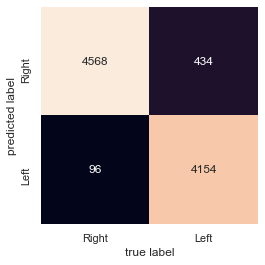

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

**RCF Profanity**

In [93]:
rfc_prof = RandomForestClassifier(n_estimators=250,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_prof.fit(prof_train2, y_train_lem)
rf_test_preds = rfc_prof.predict(prof_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Profanity')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest with Lemmatization Features and Profanity
Testing Accuracy: 0.9428

F1 Score: 0.94


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.4s finished


In [94]:
new_row = {'model': 'rfc_prof', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538
1,rfc_STOP,0.944228,0.941457
2,rfc_pro,0.942715,0.940032
3,rfc_prof,0.942823,0.940043


In [95]:
feature_importance = pd.DataFrame(sorted(list(zip(prof_columns, rfc_prof.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [96]:
feature_importance.head(10)

,feature,importance
0,catalyst,0.020277
1,fizzled,0.014301
2,Xprofanity,0.009050
3,ghostwriting,0.003734
4,depot,0.003551
5,railroad,0.003353
6,kidnapper,0.003037
7,1990,0.002922
8,fuckjob,0.002834
9,journals,0.002833


**It's interesting that we have a lower accuracy with this model, yet our newly added feature ranks as higher importance than pronouns**

**RFC Capital**

In [97]:
rfc_cap = RandomForestClassifier(n_estimators=200,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_cap.fit(cap_train2, y_train_lem)
rf_test_preds = rfc_cap.predict(cap_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Capitalization')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest with Lemmatization Features and Capitalization
Testing Accuracy: 0.9411

F1 Score: 0.9383


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


In [98]:
new_row = {'model': 'rfc_cap', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538
1,rfc_STOP,0.944228,0.941457
2,rfc_pro,0.942715,0.940032
3,rfc_prof,0.942823,0.940043
4,rfc_cap,0.941094,0.938300


In [99]:
feature_importance = pd.DataFrame(sorted(list(zip(cap_columns, rfc_cap.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [100]:
feature_importance.head(10)

,feature,importance
0,catalyst,0.020479
1,fizzled,0.013760
2,Xcapitals,0.007053
3,ghostwriting,0.003660
4,depot,0.003487
5,railroad,0.003277
6,kidnapper,0.003100
7,journals,0.003033
8,1990,0.003011
9,appointing,0.002871


**RFC Length**

In [101]:
rfc_len = RandomForestClassifier(n_estimators=250,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_len.fit(len_train2, y_train_lem)
rf_test_preds = rfc_len.predict(len_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Capitalization')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest with Lemmatization Features and Capitalization
Testing Accuracy: 0.9429

F1 Score: 0.9402


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.5s finished


In [102]:
new_row = {'model': 'rfc_len', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538
1,rfc_STOP,0.944228,0.941457
2,rfc_pro,0.942715,0.940032
3,rfc_prof,0.942823,0.940043
4,rfc_cap,0.941094,0.938300
5,rfc_len,0.942931,0.940231


**RFC Lexical**

In [103]:
rfc_lex = RandomForestClassifier(n_estimators=250,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_lex.fit(lex_train2, y_train_lem)
rf_test_preds = rfc_lex.predict(lex_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Lexical')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest with Lemmatization Features and Lexical
Testing Accuracy: 0.9431

F1 Score: 0.9404


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.5s finished


In [104]:
new_row = {'model': 'rfc_lex', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538
1,rfc_STOP,0.944228,0.941457
2,rfc_pro,0.942715,0.940032
3,rfc_prof,0.942823,0.940043
4,rfc_cap,0.941094,0.938300
5,rfc_len,0.942931,0.940231
6,rfc_lex,0.943147,0.940390


**RFC Combined**

In [105]:
rfc_combined = RandomForestClassifier(n_estimators=350,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_combined.fit(combined_train, y_train_lem)
rf_test_preds = rfc_combined.predict(combined_test)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Capitalization')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    7.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s


Random Forest with Lemmatization Features and Capitalization
Testing Accuracy: 0.9442

F1 Score: 0.9414


[Parallel(n_jobs=8)]: Done 350 out of 350 | elapsed:    0.6s finished


In [106]:
new_row = {'model': 'rfc_combined', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_basic_tfidf,0.942283,0.939538
1,rfc_STOP,0.944228,0.941457
2,rfc_pro,0.942715,0.940032
3,rfc_prof,0.942823,0.940043
4,rfc_cap,0.941094,0.938300
5,rfc_len,0.942931,0.940231
6,rfc_lex,0.943147,0.940390
7,rfc_combined,0.944228,0.941390


In [107]:
feature_importance = pd.DataFrame(sorted(list(zip(combined_columns, rfc_combined.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [109]:
feature_importance.head(20)

,feature,importance
0,catalyst,0.019090
1,fizzled,0.015221
2,Xprofanity,0.008969
3,Xstopwords,0.008097
4,Xlength,0.007800
5,Xpronouns,0.007788
6,Xcapitals,0.006084
7,Xlexical,0.005592
8,ghostwriting,0.003979
9,depot,0.003284


**Gridsearch RFC Combined**
- currently this has been replaced with combined(lexical + profanity)

In [138]:
from sklearn.model_selection import GridSearchCV

In [168]:
list(range(50,100,5))

[50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [171]:
n_estimators = list(range(50,250,10))

In [172]:
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': ['auto','sqrt','log2']
        }

grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, refit = True, verbose = 3, n_jobs = -1, scoring='accuracy')

grid.fit(lex_prof_train, y_train_lem)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 39.7min finished


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190,
                                          200, 210, 220, 230, 240]},
             scoring='accuracy', verbose=3)

In [173]:
grid_test_preds = grid.predict(lex_prof_test)

In [174]:
grid.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 240,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [175]:
accuracy = accuracy_score(y_test_lem, grid_test_preds)
f1 = f1_score(y_test_lem, grid_test_preds)

In [176]:
print('Grid RFC with Lemmatization Features and Combined')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

Grid RFC with Lemmatization Features and Combined
Testing Accuracy: 0.9402

F1 Score: 0.9383


In [177]:
new_row = {'model': 'grid_rfc_comb_lex_prof', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_pro,0.934124,0.932712
1,rfc_prof,0.933516,0.932238
2,rfc_cap,0.936711,0.935484
3,rfc_len,0.938993,0.937510
4,rfc_len,0.940362,0.939112
5,rfc_combined,0.936254,0.934847
6,grid_rfc_combined,0.934581,0.933147
7,svm_pro,0.935798,0.934165
8,svm_prof,0.935798,0.934021
9,rfc_lex,0.940362,0.939112


**RFC Combined (Lexical + Prof)**

In [110]:
lex_prof_train, lex_prof_test, lex_prof_columns = classifier_input(prof_tr = prof_train, prof_te = prof_test, 
                                                                   lex_tr = lex_train, lex_te = lex_test)

Finished Part 1
finished profanity_test
finished lexical_test
Finished train sparsing
Finished test sparsing


In [111]:
rfc_lex_prof = RandomForestClassifier(n_estimators=250,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_lex_prof.fit(lex_prof_train, y_train_lem)
rf_test_preds = rfc_lex_prof.predict(lex_prof_test)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Capitalization')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest with Lemmatization Features and Capitalization
Testing Accuracy: 0.9434

F1 Score: 0.9406


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.4s finished


In [ ]:
new_row = {'model': 'rfc_lex_prof', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)

In [117]:
results = results.sort_values(by='accuracy',ascending=False)
results

,model,accuracy,f1
1,rfc_STOP,0.944228,0.941457
7,rfc_combined,0.944228,0.941390
8,rfc_lex_prof,0.943364,0.940617
6,rfc_lex,0.943147,0.940390
5,rfc_len,0.942931,0.940231
3,rfc_prof,0.942823,0.940043
2,rfc_pro,0.942715,0.940032
0,rfc_basic_tfidf,0.942283,0.939538
4,rfc_cap,0.941094,0.938300


In [114]:
import pickle

In [115]:
# Save
with open('rfc_combined.pickle', 'wb') as f:
    pickle.dump(rfc_combined, f)

**Top 4**

In [118]:
top_train, top_test, top_columns = classifier_input(prof_tr = prof_train, prof_te = prof_test,
                                                    len_tr = len_train, len_te = len_test,  
                                                    stop_tr = stop_train, stop_te = stop_test,
                                                    lex_tr = lex_train, lex_te = lex_test)

Finished Part 1
finished profanity_test
finished length_test
finished lexical_test
Finished train sparsing
Finished test sparsing


In [126]:
rfc_top = RandomForestClassifier(n_estimators=200,max_features='log2',random_state=0,n_jobs=-1,verbose=1)
rfc_top.fit(top_train, y_train_lem)
rf_test_preds = rfc_top.predict(top_test)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Capitalization')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest with Lemmatization Features and Capitalization
Testing Accuracy: 0.9449

F1 Score: 0.9422


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


In [127]:
new_row = {'model': 'rfc_top', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_STOP,0.944228,0.941457
1,rfc_combined,0.944228,0.941390
2,rfc_lex_prof,0.943364,0.940617
3,rfc_lex,0.943147,0.940390
4,rfc_len,0.942931,0.940231
5,rfc_prof,0.942823,0.940043
6,rfc_pro,0.942715,0.940032
7,rfc_basic_tfidf,0.942283,0.939538
8,rfc_cap,0.941094,0.938300
9,rfc_top,0.944228,0.941404


**SVM with Pronouns**

In [145]:
from sklearn.svm import SVC

In [146]:
svc_pro = SVC(verbose=1)
svc_pro.fit(pro_train2, y_train_lem)
rf_test_preds = svc_pro.predict(pro_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('SVM with Lemmatization Features and Pronouns')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[LibSVM]SVM with Lemmatization Features and Pronouns
Testing Accuracy: 0.9358

F1 Score: 0.9342


In [147]:
new_row = {'model': 'svm_pro', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_pro,0.934124,0.932712
1,rfc_prof,0.933516,0.932238
2,rfc_cap,0.936711,0.935484
3,rfc_len,0.938993,0.937510
4,rfc_len,0.940362,0.939112
5,rfc_combined,0.936254,0.934847
6,grid_rfc_combined,0.934581,0.933147
7,svm_pro,0.935798,0.934165


**SVM with Profanity**

In [148]:
svc_prof = SVC(verbose=1)
svc_prof.fit(prof_train2, y_train_lem)
rf_test_preds = svc_prof.predict(prof_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('SVM with Lemmatization Features and Profanity')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[LibSVM]SVM with Lemmatization Features and Profanity
Testing Accuracy: 0.9358

F1 Score: 0.934


In [149]:
new_row = {'model': 'svm_prof', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_pro,0.934124,0.932712
1,rfc_prof,0.933516,0.932238
2,rfc_cap,0.936711,0.935484
3,rfc_len,0.938993,0.937510
4,rfc_len,0.940362,0.939112
5,rfc_combined,0.936254,0.934847
6,grid_rfc_combined,0.934581,0.933147
7,svm_pro,0.935798,0.934165
8,svm_prof,0.935798,0.934021


# SVM with Capitals

In [128]:
svc_cap = SVC(verbose=1)
svc_cap.fit(cap_train2, y_train_lem)
rf_test_preds = svc_cap.predict(cap_test2)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('SVM with Lemmatization Features and Capitals')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[LibSVM]SVM with Lemmatization Features and Capitals
Testing Accuracy: 0.9356

F1 Score: 0.9339


In [129]:
new_row = {'model': 'svm_cap', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_pro,0.934124,0.932712
1,rfc_prof,0.933516,0.932238
2,rfc_cap,0.936711,0.935484
3,rfc_combined,0.938080,0.936693
4,svm_pro,0.935798,0.934165
5,svm_prof,0.935798,0.934021
6,svm_cap,0.935646,0.933937


# SVM with Combined

In [130]:
svc_combined = SVC(verbose=1)
svc_combined.fit(combined_train, y_train_lem)
rf_test_preds = svc_combined.predict(combined_test)

accuracy = accuracy_score(y_test_lem, rf_test_preds)
f1 = f1_score(y_test_lem, rf_test_preds)
print('SVM with Lemmatization Features and Capitals')
print("Testing Accuracy: {:.4}".format(accuracy))
print()
print("F1 Score: {:.4}".format(f1))

[LibSVM]SVM with Lemmatization Features and Capitals
Testing Accuracy: 0.9355

F1 Score: 0.9338


In [131]:
new_row = {'model': 'svm_combined', 'accuracy': accuracy, 'f1': f1}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy,f1
0,rfc_pro,0.934124,0.932712
1,rfc_prof,0.933516,0.932238
2,rfc_cap,0.936711,0.935484
3,rfc_combined,0.938080,0.936693
4,svm_pro,0.935798,0.934165
5,svm_prof,0.935798,0.934021
6,svm_cap,0.935646,0.933937
7,svm_combined,0.935494,0.933833


## MN Naive Bayes

In [145]:
tfidf = TfidfVectorizer(ngram_range=(1,2))

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

In [146]:
mnb_lemma = MultinomialNB()
mnb_lemma.fit(tfidf_data_train_lem, y_train_lem)
mnb_test_preds = mnb_lemma.predict(tfidf_data_test_lem)

mnb_acc_score_lem = accuracy_score(y_test_lem, mnb_test_preds)
mnb_f1_score_lem = f1_score(y_test_lem, mnb_test_preds)
print('Multinomial Naive Bayes model accuracy')
print("Testing Accuracy: {:.4}".format(mnb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(mnb_f1_score_lem))

Multinomial Naive Bayes model accuracy
Testing Accuracy: 0.9229

F1 Score: 0.9233


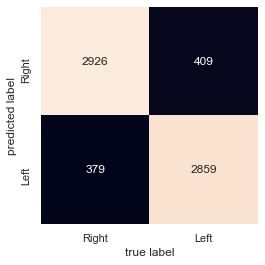

In [376]:
mat = confusion_matrix(y_test_lem, mnb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [377]:
y_test_lem.index

Int64Index([13945,  6183,  7323,  8678,  9725,   142,  8214, 10630, 13450,
             5728,
            ...
            17422,  5401,  8138, 14548, 12747, 16922, 17135,  1454,  1501,
             9295],
           dtype='int64', length=6573)

In [378]:
test = comments_df.loc[y_test_lem.index]
test['pred'] = rf_test_preds
test['pred'] = test['pred'].apply(lambda x: 'right' if x == 1 else 'left')

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [379]:
guessed_right_wrong = test[(test.comment_class != test.pred) & (test.pred == 'right')]
guessed_right_wrong.reset_index(drop=True, inplace=True)

guessed_left_wrong = test[(test.comment_class != test.pred) & (test.pred == 'left')]
guessed_left_wrong.reset_index(drop=True, inplace=True)


NameError: name 'test' is not defined

In [380]:
print("GUESSED RIGHT BUT WE WERE WRONG")
print("_______________________________")
for i in range(0,50):
    print(guessed_right_wrong.iloc[i].body)
    print('----------')

GUESSED RIGHT BUT WE WERE WRONG
_______________________________


NameError: name 'guessed_right_wrong' is not defined

In [381]:
print("GUESSED LEFT BUT WE WERE WRONG")
print("______________________________")
for i in range(0,50):
    print(guessed_left_wrong.iloc[i].body)
    print('----------')

GUESSED LEFT BUT WE WERE WRONG
______________________________


NameError: name 'guessed_left_wrong' is not defined